In [8]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import zipfile
import numpy as np
%matplotlib inline

In [9]:
# Extract IMDb SQL .db file
with zipfile.ZipFile('./Data/im.db.zip') as zipObj:
    # Extract all contents of .zip file into current directory
    zipObj.extractall(path='./Data/')
    
# Create connection to IMDb DB
conn = sqlite3.connect('./data/im.db')

In [10]:
conn = sqlite3.Connection("./data/im.db")

In [11]:
# Suppress Scientific Notatation

pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Creating dataframes from im.db.move_basics and im.db.movie_ratings



In [12]:
# Query to pull relevant data from im.db

# I think there's probably a better/more efficient query that would pull everything we need but I was getting stuck.
# Instead I decided to do two queries and merge the resulting dataframes.

q2 = """
SELECT
    movie_id,
    primary_title,
    start_year,
    genres,
    directors.person_id AS director_id,
    writers.person_id AS writer_id,  
    movie_ratings.averagerating,
    movie_ratings.numvotes
    
FROM
    movie_basics
    JOIN
        movie_ratings
            USING(movie_id)
    JOIN
        directors
            USING(movie_id)
    JOIN
        writers
            USING(movie_id)
    
WHERE
    start_year >= 2010 AND
    start_year <= 2022


GROUP BY
    movie_basics.movie_id
;
"""
q2_result = pd.read_sql(q2, conn)
q2_result

,movie_id,primary_title,start_year,genres,director_id,writer_id,averagerating,numvotes
0,tt0063540,Sunghursh,2013,"Action,Crime,Drama",nm0712540,nm0023551,7.00,77
1,tt0069049,The Other Side of the Wind,2018,Drama,nm0000080,nm0000080,6.90,4517
2,tt0069204,Sabse Bada Sukh,2018,"Comedy,Drama",nm0611531,nm0347899,6.10,13
3,tt0100275,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy",nm0749914,nm0749914,6.50,119
4,tt0137204,Joe Finds Grace,2017,"Adventure,Animation,Comedy",nm0365480,nm0365480,8.10,263
...,...,...,...,...,...,...,...,...
63083,tt9911774,Padmavyuhathile Abhimanyu,2019,Drama,nm10536451,nm10536451,8.40,365
63084,tt9913084,Diabolik sono io,2019,Documentary,nm0812850,nm0812850,6.20,6
63085,tt9914286,Sokagin Çocuklari,2019,"Drama,Family",nm4394529,nm1902682,8.70,136
63086,tt9914642,Albatross,2017,Documentary,nm5300859,nm5300859,8.50,8


In [13]:
q2_result.shape

(63088, 8)

   - Movie Title
   - Genre(s)
   - Release Year
   - Rating (R/PG-13/etc)
   - Total Gross
   - Production Budget
   - Associated Actors/Star/TBD
   - Writer
   - Director
   - Run Time
   - IMDB Rating
   - The Movie Database Popularity (still need to understand what this is)
   - The Movie Database Vote Count
   
   - season of release
   - inflation relative to budget/gross -- pull data & correlate with release year
   - franchise?

In [14]:
# query to create a mapping table so that we can replace director/writer ID with real names.

q3 = """
SELECT
    person_id,
    primary_name
        
FROM
    persons
   
    
GROUP BY
    person_id
;
"""
q3_result = pd.read_sql(q3, conn)
q3_result

,person_id,primary_name
0,nm0000002,Lauren Bacall
1,nm0000003,Brigitte Bardot
2,nm0000005,Ingmar Bergman
3,nm0000006,Ingrid Bergman
4,nm0000007,Humphrey Bogart
...,...,...
606643,nm9993494,Amjad Ali
606644,nm9993573,Lakisha Louissaint
606645,nm9993616,Ryan Mac Lennan
606646,nm9993650,Marcin Balcerak


In [15]:
# merge primary_name from the persons table onto our dataframe where director_id matches person_id
directors = q2_result.merge(q3_result, how='left', left_on='director_id', right_on='person_id')

In [16]:
# rename primary_name to director_name
directors = directors.rename({"primary_name":"director_name"}, axis="columns")

In [17]:
# merge primary_name from the persons table onto our dataframe where writer_id matches person_id
writers = directors.merge(q3_result, how='left', left_on='writer_id', right_on='person_id')

In [18]:
# rename primary_name to director_name
df = writers.rename({"primary_name":"writer_name"}, axis="columns")

In [19]:
# drop extraneous columns
df = df.drop(columns=['director_id', 'writer_id', 'person_id_x', 'person_id_y'])

In [20]:
# shape matches the length of our original table.
print(df.shape) 
df.head()

(63088, 8)


,movie_id,primary_title,start_year,genres,averagerating,numvotes,director_name,writer_name
0,tt0063540,Sunghursh,2013,"Action,Crime,Drama",7.00,77,Harnam Singh Rawail,Abrar Alvi
1,tt0069049,The Other Side of the Wind,2018,Drama,6.90,4517,Orson Welles,Orson Welles
2,tt0069204,Sabse Bada Sukh,2018,"Comedy,Drama",6.10,13,Hrishikesh Mukherjee,Gulzar
3,tt0100275,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy",6.50,119,Raoul Ruiz,Raoul Ruiz
4,tt0137204,Joe Finds Grace,2017,"Adventure,Animation,Comedy",8.10,263,Anthony Harrison,Anthony Harrison


In [21]:
# some missing values here that we can either deal with or try to fill in from the other sources.
df.isna().sum()

movie_id           0
primary_title      0
start_year         0
genres           471
averagerating      0
numvotes           0
director_name      1
writer_name        0
dtype: int64

In [22]:
conn.close()

In [23]:
# some titles were duplicated
df['primary_title'].duplicated().sum()

3275

### Data contains 903 records where primary title AND start year are duplicated. ~1.4% of dataset

#### Drop as we have no easy way to match with budget data when both columns are duplicated.


In [24]:
# Drop rows where primary title and start year are duplicated.

df = df.drop_duplicates(subset=['primary_title', 'start_year'])

In [25]:
df.shape

(62622, 8)

# Read in budget data from The Numbers

In [26]:
df_budget = pd.read_csv('./data/tn.movie_budgets.csv', index_col=0)

In [27]:
# convert release_date to a new release_year column
df_budget['release_year'] = df_budget['release_date'].apply(lambda x: int(x[-4:]))

In [28]:
df_budget.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
id,,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",2017


In [29]:
df_budget.shape

(5782, 6)

In [30]:
# create simple budget df to merge with main df
df_budget_simple = df_budget[['movie', 'production_budget', 'worldwide_gross', 'release_year']]

# Inner merge on budget data

In [31]:
# merge simple budget df to main df on movie name & year
df2 = df.merge(df_budget_simple, how='inner', left_on=['primary_title', 'start_year'], right_on=['movie', 'release_year'])

In [32]:
df2.isna().sum()

movie_id             0
primary_title        0
start_year           0
genres               0
averagerating        0
numvotes             0
director_name        0
writer_name          0
movie                0
production_budget    0
worldwide_gross      0
release_year         0
dtype: int64

In [33]:
df2.shape

(1448, 12)

In [34]:
# create dataframe containing records where inner join created primary_title == duplicated
df_dup = df2.loc[df2['primary_title'].duplicated(keep=False) == True]

In [35]:
df_dup.sort_values(by='primary_title').head()

,movie_id,primary_title,start_year,genres,averagerating,numvotes,director_name,writer_name,movie,production_budget,worldwide_gross,release_year
108,tt0955308,Robin Hood,2010,"Action,Adventure,Drama",6.60,239480,Ridley Scott,Brian Helgeland,Robin Hood,"$210,000,000","$322,459,006",2010
1290,tt4532826,Robin Hood,2018,"Action,Adventure,Thriller",5.30,41588,Otto Bathurst,David James Kelly,Robin Hood,"$99,000,000","$84,747,441",2018


In [36]:
df2['production_budget'] = df2['production_budget'].str.replace('$','', regex=True)

In [37]:
df2['production_budget'] = df2['production_budget'].str.replace(',','', regex=True)

In [38]:
df2['production_budget'] = df2['production_budget'].astype(float)

In [39]:
df2['worldwide_gross'] = df2['worldwide_gross'].str.replace(',','', regex=True)

In [40]:
df2['worldwide_gross'] = df2['worldwide_gross'].str.replace('$','', regex=True)

In [41]:
df2['worldwide_gross'] = df2['worldwide_gross'].astype(float)

In [42]:
df2['profit'] = (df2['worldwide_gross'] - df2['production_budget'])

In [43]:
df2['profit'] = df2['profit'].round()

In [44]:
df2['genres'] = df2['genres'].str.split(",")

In [45]:
df2.shape

(1448, 13)

In [46]:
df2.head()

,movie_id,primary_title,start_year,genres,averagerating,numvotes,director_name,writer_name,movie,production_budget,worldwide_gross,release_year,profit
0,tt0249516,Foodfight!,2012,"[Action, Animation, Comedy]",1.90,8248,Lawrence Kasanoff,Sean Catherine Derek,Foodfight!,45000000.00,73706.00,2012,-44926294.00
1,tt0359950,The Secret Life of Walter Mitty,2013,"[Adventure, Comedy, Drama]",7.30,275300,Ben Stiller,Steve Conrad,The Secret Life of Walter Mitty,91000000.00,187861183.00,2013,96861183.00
2,tt0365907,A Walk Among the Tombstones,2014,"[Action, Crime, Drama]",6.50,105116,Scott Frank,Lawrence Block,A Walk Among the Tombstones,28000000.00,62108587.00,2014,34108587.00
3,tt0369610,Jurassic World,2015,"[Action, Adventure, Sci-Fi]",7.00,539338,Colin Trevorrow,Michael Crichton,Jurassic World,215000000.00,1648854864.00,2015,1433854864.00
4,tt0376136,The Rum Diary,2011,"[Comedy, Drama]",6.20,94787,Bruce Robinson,Bruce Robinson,The Rum Diary,45000000.00,21544732.00,2011,-23455268.00


# LEFT Merge on Budget Data

In [47]:
# merge simple budget df to main df on movie name & year
df3 = df.merge(df_budget_simple, how='left', left_on=['primary_title', 'start_year'], right_on=['movie', 'release_year'])

In [48]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62622 entries, 0 to 62621
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           62622 non-null  object 
 1   primary_title      62622 non-null  object 
 2   start_year         62622 non-null  int64  
 3   genres             62155 non-null  object 
 4   averagerating      62622 non-null  float64
 5   numvotes           62622 non-null  int64  
 6   director_name      62621 non-null  object 
 7   writer_name        62622 non-null  object 
 8   movie              1448 non-null   object 
 9   production_budget  1448 non-null   object 
 10  worldwide_gross    1448 non-null   object 
 11  release_year       1448 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 6.2+ MB


# Split Genres by commas

In [49]:
df3['genres'] = df3['genres'].str.split(",")

In [50]:
#drop rows with no genres
df3 = df3.dropna(subset=['genres'])

# Generate Profit Column

In [51]:
df3['production_budget'] = df3['production_budget'].str.replace('$','', regex=True)

In [52]:
df3['production_budget'] = df3['production_budget'].str.replace(',','', regex=True)

In [53]:
df3['production_budget'] = df3['production_budget'].astype(float)

In [54]:
df3['worldwide_gross'] = df3['worldwide_gross'].str.replace(',','', regex=True)

In [55]:
df3['worldwide_gross'] = df3['worldwide_gross'].str.replace('$','', regex=True)

In [56]:
df3['worldwide_gross'] = df3['worldwide_gross'].astype(float)

In [57]:
df3['profit'] = (df3['worldwide_gross'] - df3['production_budget'])

In [58]:
df3['profit'] = df3['profit'].round()

In [59]:
df4 = df3.replace(np.nan, 0, regex=True)


In [60]:
df3['profit'].sort_values().head()

53643   -200237650.00
1706    -110450242.00
47183    -90000000.00
38204    -79448583.00
765      -69533984.00
Name: profit, dtype: float64

In [61]:
df4.sort_values('profit')

,movie_id,primary_title,start_year,genres,averagerating,numvotes,director_name,writer_name,movie,production_budget,worldwide_gross,release_year,profit
53643,tt6565702,Dark Phoenix,2019,"[Action, Adventure, Sci-Fi]",6.00,24451,Simon Kinberg,John Byrne,Dark Phoenix,350000000.00,149762350.00,2019.00,-200237650.00
1706,tt1305591,Mars Needs Moms,2011,"[Adventure, Animation, Family]",5.40,19823,Simon Wells,Berkeley Breathed,Mars Needs Moms,150000000.00,39549758.00,2011.00,-110450242.00
47183,tt5519340,Bright,2017,"[Action, Crime, Fantasy]",6.40,147834,David Ayer,Max Landis,Bright,90000000.00,0.00,2017.00,-90000000.00
38204,tt4192918,The Promise,2017,[Comedy],8.80,53,Candy J. Beard,Candy J. Beard,The Promise,90000000.00,10551417.00,2017.00,-79448583.00
765,tt1041804,The Nutcracker in 3D,2010,"[Action, Family, Fantasy]",4.30,3119,Andrey Konchalovskiy,Andrey Konchalovskiy,The Nutcracker in 3D,90000000.00,20466016.00,2010.00,-69533984.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9968,tt1825683,Black Panther,2018,"[Action, Adventure, Sci-Fi]",7.30,516148,Ryan Coogler,Jack Kirby,Black Panther,200000000.00,1348258224.00,2018.00,1148258224.00
307,tt0848228,The Avengers,2012,"[Action, Adventure, Sci-Fi]",8.10,1183655,Joss Whedon,Zak Penn,The Avengers,225000000.00,1517935897.00,2012.00,1292935897.00
25282,tt2820852,Furious 7,2015,"[Action, Crime, Thriller]",7.20,335074,James Wan,Chris Morgan,Furious 7,190000000.00,1518722794.00,2015.00,1328722794.00
44,tt0369610,Jurassic World,2015,"[Action, Adventure, Sci-Fi]",7.00,539338,Colin Trevorrow,Michael Crichton,Jurassic World,215000000.00,1648854864.00,2015.00,1433854864.00


## Visualizing - Most common genres

In [62]:
genre_count = {}

for movie in df3['genres']:
    for genre in movie:
        if genre in genre_count.keys():
            genre_count[genre] +=1
        else:
            genre_count[genre] = 1
        

In [63]:
genre_count

{'Action': 6397,
 'Crime': 4304,
 'Drama': 28609,
 'Comedy': 15926,
 'Fantasy': 2015,
 'Adventure': 3439,
 'Animation': 1504,
 'History': 2277,
 'Documentary': 11071,
 'Mystery': 2910,
 'Biography': 2875,
 'Sci-Fi': 2117,
 'Thriller': 7816,
 'Horror': 7203,
 'Family': 3002,
 'Romance': 6054,
 'War': 744,
 'Music': 1317,
 'Sport': 866,
 'Western': 265,
 'Musical': 624,
 'News': 398,
 'Reality-TV': 7,
 'Game-Show': 2,
 'Adult': 2,
 'Short': 1}

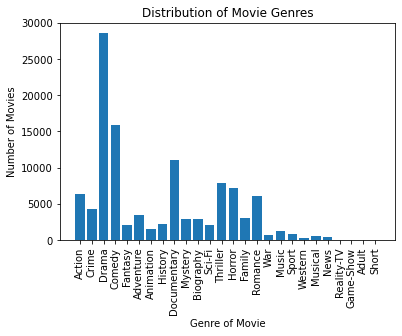

In [64]:
fig, ax = plt.subplots()
ax.bar(x = list(genre_count.keys()), height = list(genre_count.values()));
ax.tick_params(axis='x', labelrotation = 90);
ax.set_ylabel('Number of Movies');
ax.set_xlabel('Genre of Movie');
ax.set_title('Distribution of Movie Genres');

# Finding average IMDB rating per genre

In [65]:
cumulative_rating = []
genres = list(genre_count.keys())
        
for genre in genre_count:
    rating = df3.loc[df3['genres'].astype(str).str.contains(genre), 'averagerating']
    rating = rating.cumsum().iloc[-1]
    average_rating = round(rating / genre_count[genre], 2)
    cumulative_rating.append(average_rating)

genre_ratings = dict(zip(genres, cumulative_rating))
genre_ratings
         

{'Action': 5.8,
 'Crime': 6.1,
 'Drama': 6.39,
 'Comedy': 6.01,
 'Fantasy': 5.91,
 'Adventure': 6.12,
 'Animation': 6.25,
 'History': 6.96,
 'Documentary': 7.32,
 'Mystery': 5.91,
 'Biography': 7.1,
 'Sci-Fi': 5.48,
 'Thriller': 5.63,
 'Horror': 5.0,
 'Family': 6.34,
 'Romance': 6.15,
 'War': 6.49,
 'Music': 9.72,
 'Sport': 6.83,
 'Western': 5.83,
 'Musical': 6.44,
 'News': 7.24,
 'Reality-TV': 6.93,
 'Game-Show': 7.3,
 'Adult': 2.7,
 'Short': 8.8}

# Find average profit by genre

In order to correctly compute average profit, we need to calculate a new genre count for movies that include profit data.

In [66]:
# find genre count for each record that includes profit information.
profit_count = {}

for movie in df2['genres']:
    for genre in movie:
        if genre in profit_count.keys():
            profit_count[genre] +=1
        else:
            profit_count[genre] = 1

In [67]:
profit_count

{'Action': 444,
 'Animation': 101,
 'Comedy': 510,
 'Adventure': 349,
 'Drama': 705,
 'Crime': 232,
 'Sci-Fi': 132,
 'Family': 91,
 'Romance': 183,
 'Thriller': 257,
 'Horror': 177,
 'Mystery': 125,
 'Biography': 131,
 'History': 38,
 'War': 17,
 'Fantasy': 121,
 'Sport': 33,
 'Music': 45,
 'Western': 11,
 'Documentary': 19,
 'Musical': 8}

In [68]:
# create dictionary with genres as keys and mean profit as values.

cumulative_profit = []
genres = list(profit_count.keys())

        
for genre in profit_count:
    profit = df2.loc[df2['genres'].astype(str).str.contains(genre), 'profit']
    profit = profit.cumsum().iloc[-1]       
    average_profit = round(profit / profit_count[genre], 2)
    cumulative_profit.append(average_profit)

genre_profits = dict(zip(genres, cumulative_profit))
genre_profits

{'Action': 161618671.85,
 'Animation': 279728090.58,
 'Comedy': 93709341.62,
 'Adventure': 245671972.59,
 'Drama': 47499251.62,
 'Crime': 48633093.89,
 'Sci-Fi': 252720489.92,
 'Family': 131159824.6,
 'Romance': 46272697.14,
 'Thriller': 83113839.28,
 'Horror': 50111344.15,
 'Mystery': 65953309.24,
 'Biography': 55798194.65,
 'History': 53642267.76,
 'War': 29517132.12,
 'Fantasy': 152652851.51,
 'Sport': 28300758.45,
 'Music': 91593874.38,
 'Western': 47218943.0,
 'Documentary': 21558059.47,
 'Musical': 182863946.38}

for movies we have budget data--which genres have more flops?

In [69]:
# create dictionary with genres as keys and median profit as values.

median_genres = []
genres = list(profit_count.keys())

        
for genre in profit_count:
    profit = df2.loc[df2['genres'].astype(str).str.contains(genre), 'profit']
           
    median_profit = round(profit.median(), 2)
    median_genres.append(median_profit)

genre_medians = dict(zip(genres, median_genres))
genre_medians

{'Action': 53927638.0,
 'Animation': 196392649.0,
 'Comedy': 29817257.5,
 'Adventure': 129276941.0,
 'Drama': 12341016.0,
 'Crime': 13630709.5,
 'Sci-Fi': 121888904.0,
 'Family': 42150788.0,
 'Romance': 17621449.0,
 'Thriller': 27666013.0,
 'Horror': 15965567.0,
 'Mystery': 33735965.0,
 'Biography': 17425450.0,
 'History': 20889821.0,
 'War': -1973745.0,
 'Fantasy': 41647574.0,
 'Sport': 14217912.0,
 'Music': 10439214.0,
 'Western': -2240304.0,
 'Documentary': 1653715.0,
 'Musical': 17276337.5}

In [70]:
df2.loc[df2['genres'].astype(str).str.contains(genre), 'profit']

171      35552675.00
295      -5068194.00
324      -8968068.00
436     302665550.00
659      -1997564.00
862      42527466.00
1024     -1000000.00
1047   1099199706.00
Name: profit, dtype: float64

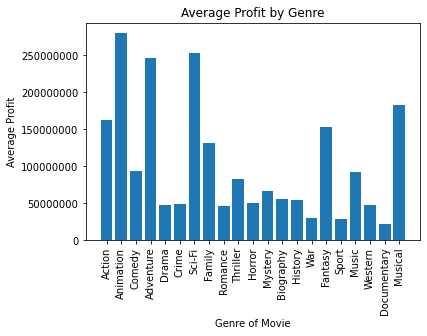

In [71]:
avg_profit, ax = plt.subplots()
ax.bar(x = list(genre_profits.keys()), height = list(genre_profits.values()));
ax.tick_params(axis='x', labelrotation = 90);
ax.ticklabel_format(axis='y',style='plain')
ax.set_ylabel('Average Profit');
ax.set_xlabel('Genre of Movie');
ax.set_title('Average Profit by Genre');

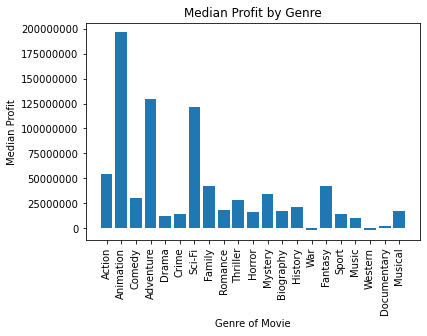

In [77]:
med_profit, ax = plt.subplots()
ax.bar(x = list(genre_medians.keys()), height = list(genre_medians.values()));
ax.tick_params(axis='x', labelrotation = 90);
ax.ticklabel_format(axis='y',style='plain')
ax.set_ylabel('Median Profit');
ax.set_xlabel('Genre of Movie');
ax.set_title('Median Profit by Genre')

plt.savefig('med_profit');

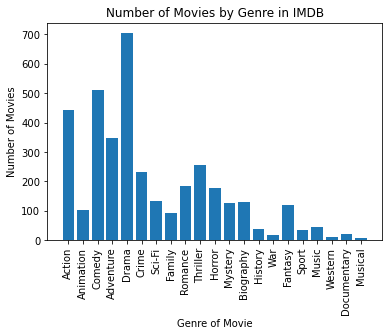

In [78]:
fig, ax = plt.subplots()
ax.bar(x = list(profit_count.keys()), height = list(profit_count.values()));
ax.tick_params(axis='x', labelrotation = 90);
ax.set_ylabel('Number of Movies');
ax.set_xlabel('Genre of Movie');
ax.set_title('Number of Movies by Genre in IMDB');

plt.savefig('med_profit')

In [57]:
#Restore default display settings
pd.reset_option('display.float_format')